# Nonlinear Smoothing

In this demo, we will look at dynamical systems with nonlinear state transitions. We will start with a one-dimensional problem; the number of rabbits on an island. This problem seems overly simple, but it is a good way to demonstrate the basic pipeline of working with ReactiveMP. The second problem, that of tracking a pendulum, is a bit more realistic in that we translate a differential equation in state-space model form to a probabilistic model. This requires more effort on the part of model specification, but not too much on the part of inference.

## 1. Rabbit population size

We consider a model for the number of rabbits on a particular island. We assume the population size follows a [logistic map](https://en.wikipedia.org/wiki/Logistic_map): initially, it grows exponentially, but as the number of rabbits increases, so does the number of foxes. At some point, population size will drop again. But as the number of rabbits drops, so does the number of foxes, which means the number of rabbits can grow again. We express the change in the population with the following nonlinear state transition:

$$x_{t+1} = r \cdot x_t(1-x_t)$$

where $r$ is a fertility parameter, reflecting how fast the number of rabbits can grow. $x$ does not reflect the number of rabbits, but rather the proportion of rabbits relative to a maximum population $N$ on the island. This means $x$ is bounded in the interval $[0,1]$.

Every month, we count the number of rabbits $y_t$. We assume that these counts are noisy: sometimes, we count one rabbit twice and sometimes, we miss one. This noise is expressed as a Gaussian distribution centered at $0$, with some measurement noise precision.

In [1]:
# Import libraries to julia workspace
using Rocket
using GraphPPL
using ReactiveMP
using Plots 
using Distributions
using StableRNGs

In [2]:
# Range for observation noise
rng = StableRNG(1234);

# Length of time-series
T = 36

# Maximum population size
N = 100

# Fertility parameter (0 < r < 4)
fertility = 3.2

# Measurement noise precision
noise_precision = 0.01

# Initial proportion of rabbits
x0 = 0.04

# Initialize data array
states = zeros(T,)
observations = zeros(T,)

# Initialize previous state variable
prev_state = x0

for t = 1:T
    
    # State transition
    states[t] = fertility*prev_state*(1-prev_state)
    
    # Observation likelihood
    observations[t] = max(round(N*states[t] .+ sqrt(inv(noise_precision))*randn(rng,)[1]), 0.)
    
    # Update "previous state"
    prev_state = states[t]
    
end    

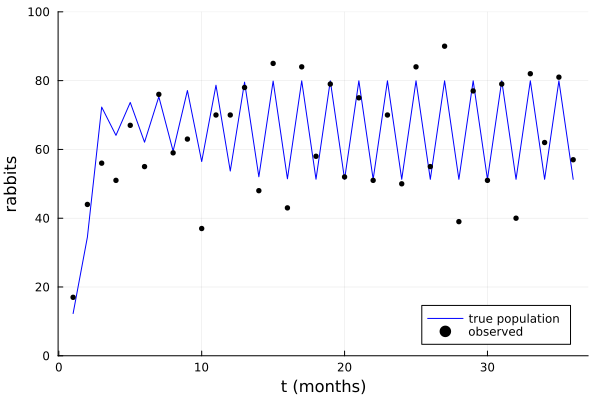

In [3]:
# Inspect data
plot(1:T, states.*N, color="blue", xlabel="t (months)", ylabel="rabbits", label="true population")
scatter!(1:T, observations, ylims=[0, N], color="black", markersize=3, label="observed", legend=:bottomright)

### Model specification

We define a state-space model, consisting of a state transition between $x_{t-1}$ and $x_t$ and an observation likelihood between $y_t$ and $x_t$. These are conditional distributions, which we model with certain parametric distributions. In this case, mostly Gaussian distributions.

- The states are the proportion of rabbits relative to a maximum N. To model the rabbit counts, we must multiply the states with the maximum population number $N$. Furthermore, we said that the rabbit counts are noisy (see 'Generate data' section). We assumed that we were counting some rabbits twice and missed others. That justifies using a white noise term: the current rabbit count is Gaussian distributed centered on the current state times the maximum population. For the sake of simplicity in this demo, we assume that we know the size of the noise. It is however straightforward to add a prior for measurement noise and estimate it simultaneously.

- The state transition that we defined above (the [logistic map](https://en.wikipedia.org/wiki/Logistic_map)) is nonlinear in nature (polynomial order 2). To capture this mapping, we have to use a "Delta" node. The "Delta{Unscented}" node performs an unscented transform to approximate the given function (exact up to polynomial order 3) and approximates the result with a Gaussian distribution.

- We have to specify a prior distribution for the states. Below, we choose a Gaussian distribution, but this is actually not completely valid. In a model using the logistic map, the states are confined to the interval $[0, 1]$. We would therefore have to use a bounded distribution, such as the [Beta](https://en.wikipedia.org/wiki/Beta_distribution). However, a Beta process is much more complicated than a Gaussian process and we will therefore avoid it here.

- We have to specify a prior for the fertility parameter $r$. It is supposed to be a strictly positive number, so ideally we would use something like a [Gamma](https://en.wikipedia.org/wiki/Gamma_distribution) or [log-Normal](https://en.wikipedia.org/wiki/Log-normal_distribution) distribution. However, this, again, complicates inference and we have therefore opted for a Gaussian distribution.

We are going to specify the state-space model in recursive form, i.e. we only specify the previous state, the state transition and the likelihood, and update estimates as observations arrive. We will probably observe that our estimates start out relatively poor but improve over time. 

In [4]:
g(x, r) = r*x*(1-x)

@model function rabbit_population(n, precision=10)
    x = randomvar(n)
    y = datavar(Float64, n)

    r ~ Normal(μ=1.0, σ²=10.0)
    x_0 ~ Normal(μ=0.5, σ²=2.0)

    x_prev = x_0
    for i in 1:n
        x[i] ~ g(x_prev, r) where {meta = UT()}
        y[i] ~ Normal(μ=N*x[i], γ=precision)
        
        x_prev = x[i]
    end

end

In [5]:
n = length(observations)
imessages = (r = NormalMeanVariance(0.0, 10.0), )
result = inference(model = Model(rabbit_population, n, noise_precision), options=(limit_stack_depth=100, ), initmessages=imessages, data=(y=observations,), free_energy=true, showprogress=true)

Inference results:
-----------------------------------------
Free Energy: Real[143.801]
-----------------------------------------
x_0 = NormalWeightedMeanPrecision{Float64}(xi=0.25, w=0.5)
r   = NormalWeightedMeanPrecision{Float64}(xi=9.246693356738888, w=2.7316201303034404)...
x   = NormalWeightedMeanPrecision{Float64}[NormalWeightedMeanPrecision{Float64}(xi=17....


In [6]:
m_x_t, v_x_t = mean.(result.posteriors[:x]), cov.(result.posteriors[:x]);

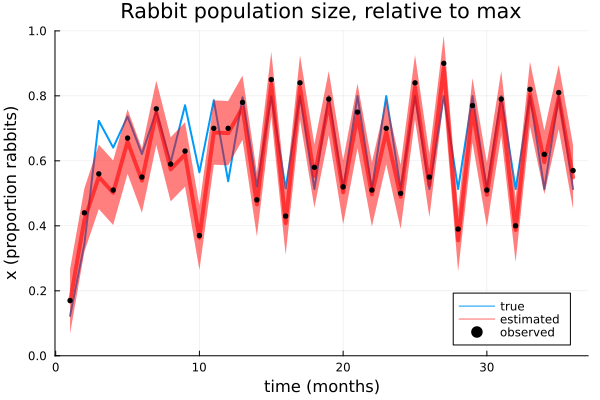

In [7]:
# Plot true states and overlay estimates
plot(1:T, states, linewidth=2, ylims=[0., 1.], xlabel="time (months)", ylabel="x (proportion rabbits)", label="true", legend=:bottomright)
plot!(1:T, m_x_t, linewidth=4, color="red", ribbon=[sqrt.(v_x_t) sqrt.(v_x_t)], alpha=0.6, label="estimated")
scatter!(1:T, observations./N, color="black", markersize=3, label="observed", legend=:bottomright)
title!("Rabbit population size, relative to max")

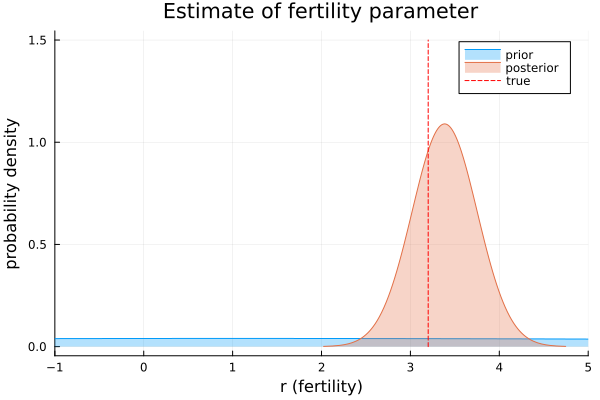

In [8]:
# Plot estimate of fertility parameter r
using StatsPlots

estimated = Normal(mean(result.posteriors[:r]),var(result.posteriors[:r]))
prior = Normal(1.0, 10.0)
plot(prior, label="prior", fillalpha=0.3, fillrange = 0,)
plot!(estimated, label="posterior", fillalpha=0.3, fillrange = 0)
plot!([(fertility,0),(fertility, 1.5)], linecolor = :red, linestyle = :dash, label="true")

title!("Estimate of fertility parameter")
xlabel!("r (fertility)")
ylabel!("probability density")
xlims!(-1.0, 5.0)